In [6]:
# %load email_pr.py
# 用 PageRank 挖掘希拉里邮件中的重要任务关系
import pandas as pd
import networkx as nx
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt

# 数据加载
emails = pd.read_csv("./input/Emails.csv")
# 读取别名文件
file = pd.read_csv("./input/Aliases.csv")
aliases = {}
for index, row in file.iterrows():
    aliases[row["Alias"]] = row["PersonId"]
# 读取人名文件
file = pd.read_csv("./input/Persons.csv")
persons = {}
for index, row in file.iterrows():
    persons[row["Id"]] = row["Name"]

In [7]:
# 针对别名进行转换
def unify_name(name):
    # 姓名统一小写
    name = str(name).lower()
    # 去掉，和@后面的内容
    name = name.replace(",", "").split("@")[0]
    # 别名转换
    if name in aliases.keys():
        return persons[aliases[name]]
    return name

In [8]:
# 画网络图
def show_graph(graph):
    # 使用 Spring Layout 布局，类似中心放射状
    positions = nx.spring_layout(graph)
    # 设置网络图中的节点大小，大小与 pagerank 值相关，因为 pagerank 值很小所以需要*20000
    nodesize = [x["pagerank"] * 20000 for v, x in graph.nodes(data=True)]
    # 设置网络图中的边长度
    edgesize = [np.sqrt(e[2]["weight"]) for e in graph.edges(data=True)]
    # 绘制节点
    nx.draw_networkx_nodes(graph, positions, node_size=nodesize, alpha=0.4)
    # 绘制边
    nx.draw_networkx_edges(
        graph,
        positions,
        # edge_size=edgesize,
        alpha=0.2,
    )
    # 绘制节点的 label
    nx.draw_networkx_labels(graph, positions, font_size=10)
    # 输出希拉里邮件中的所有人物关系图
    plt.show()

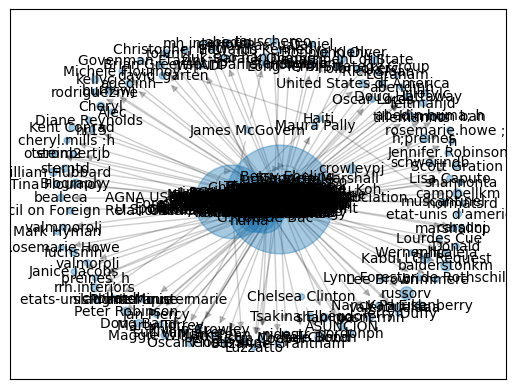

In [9]:
# 将寄件人和收件人的姓名进行规范化
emails.MetadataFrom = emails.MetadataFrom.apply(unify_name)
emails.MetadataTo = emails.MetadataTo.apply(unify_name)

# 设置遍的权重等于发邮件的次数
edges_weights_temp = defaultdict(list)
for row in zip(emails.MetadataFrom, emails.MetadataTo, emails.RawText):
    temp = (row[0], row[1])
    if temp not in edges_weights_temp:
        edges_weights_temp[temp] = 1
    else:
        edges_weights_temp[temp] = edges_weights_temp[temp] + 1

# 转化格式 (from, to), weight => from, to, weight
edges_weights = [(key[0], key[1], val) for key, val in edges_weights_temp.items()]

# 创建一个有向图
graph = nx.DiGraph()
# 设置有向图中的路径及权重 (from, to, weight)
graph.add_weighted_edges_from(edges_weights)
# 计算每个节点（人）的 PR 值，并作为节点的 pagerank 属性
pagerank = nx.pagerank(graph)
# 获取每个节点的 pagerank 数值
pagerank_list = {node: rank for node, rank in pagerank.items()}
# 将 pagerank 数值作为节点的属性
nx.set_node_attributes(graph, name="pagerank", values=pagerank_list)
# 画网络图
show_graph(graph)

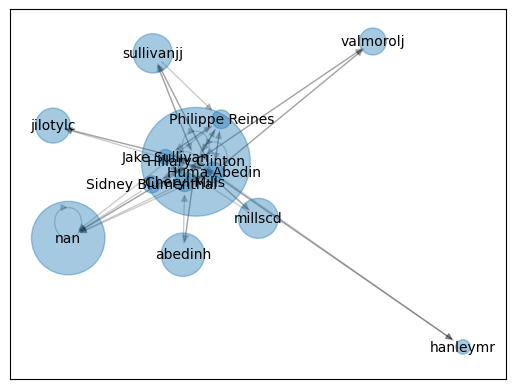

In [10]:
# 将完整的图谱进行精简
# 设置 PR 值的阈值，筛选大于阈值的重要核心节点
pagerank_threshold = 0.005
# 复制一份计算好的网络图
small_graph = graph.copy()
# 剪掉 PR 值小于 pagerank_threshold 的节点
for n, p_rank in graph.nodes(data=True):
    if p_rank["pagerank"] < pagerank_threshold:
        small_graph.remove_node(n)
# 画网络图
show_graph(small_graph)